In [1]:
%cd ../

/home/eli/AnacondaProjects/HTFATorch


In [2]:
import logging
import numpy as np
import re

import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils

In [3]:
%matplotlib inline

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
lepping_db = niidb.FMriActivationsDb('data/sound_depression.db', mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz')

In [6]:
dtfa = DTFA.DeepTFA([b for b in lepping_db.all() if 'response' not in b.task], mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz', num_factors=100, embedding_dim=2)

05/20/2019 13:36:43 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-nonmusic_run-5_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
05/20/2019 13:36:45 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-music_run-3_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
05/20/2019 13:36:47 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-music_run-2_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
05/20/2019 13:36:49 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/

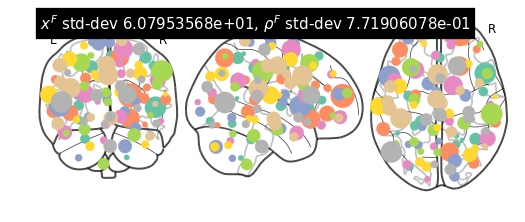

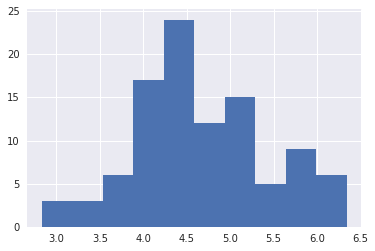

(<nilearn.plotting.displays.OrthoProjector at 0x7f1541e7eda0>,
 tensor([[-30.0371, -82.1621, -11.5321],
         [ 49.6325,  16.2068,   2.4243],
         [ -1.3922,  35.5202,  10.4884],
         [-17.5763, -34.8624,  44.7771],
         [ 19.3266, -49.7431, -50.3561],
         [ 39.2984, -52.9407,  54.7997],
         [-24.5255, -38.9795, -30.7438],
         [  2.1778,  32.4747,  57.0466],
         [-31.2077,  -7.5710,   4.5357],
         [ 25.3203, -53.7702,  12.5626],
         [ 18.8238, -58.9136, -14.1230],
         [ 47.5179,  -3.0451,  46.0923],
         [-42.4759, -46.7909,  59.3180],
         [ 11.9707, -66.7764,  54.8703],
         [-23.8612,  -6.6904,  32.9878],
         [-40.0621,  41.0277,  -3.5967],
         [ 22.8648,  57.2606,  15.0041],
         [ 37.4190, -78.5177,  11.9042],
         [ 40.6607,  41.3746,  23.2435],
         [-57.7223, -42.3390,  -1.6450],
         [ 22.8885,  23.6509,  -9.3060],
         [-44.1659,  28.7470,  26.3842],
         [ 38.5080, -74.2537, -15.8

In [7]:
dtfa.visualize_factor_embedding()

In [8]:
losses = dtfa.train(num_steps=1000, learning_rate={'q': 1e-2, 'p': 1e-4}, log_level=logging.INFO, num_particles=1,
                    batch_size=50, use_cuda=True, checkpoint_steps=100, blocks_batch_size=20, patience=100)

05/20/2019 13:43:04 [Epoch 1] (20196ms) Posterior free-energy 1.12134285e+09 = KL from prior 1.21977800e+06 - log-likelihood -1.12012301e+09
05/20/2019 13:43:04 Saving checkpoint...
05/20/2019 13:43:24 [Epoch 2] (19944ms) Posterior free-energy 1.08330010e+09 = KL from prior 1.14828175e+06 - log-likelihood -1.08215168e+09
05/20/2019 13:43:43 [Epoch 3] (19570ms) Posterior free-energy 1.05240064e+09 = KL from prior 1.09290350e+06 - log-likelihood -1.05130771e+09
05/20/2019 13:44:03 [Epoch 4] (19498ms) Posterior free-energy 1.03184595e+09 = KL from prior 1.04427788e+06 - log-likelihood -1.03080166e+09
05/20/2019 13:44:22 [Epoch 5] (19553ms) Posterior free-energy 1.01437235e+09 = KL from prior 1.00293219e+06 - log-likelihood -1.01336947e+09
05/20/2019 13:44:42 [Epoch 6] (19487ms) Posterior free-energy 1.00043917e+09 = KL from prior 9.61228750e+05 - log-likelihood -9.99478144e+08
05/20/2019 13:45:01 [Epoch 7] (19522ms) Posterior free-energy 9.89378240e+08 = KL from prior 9.26667062e+05 - log

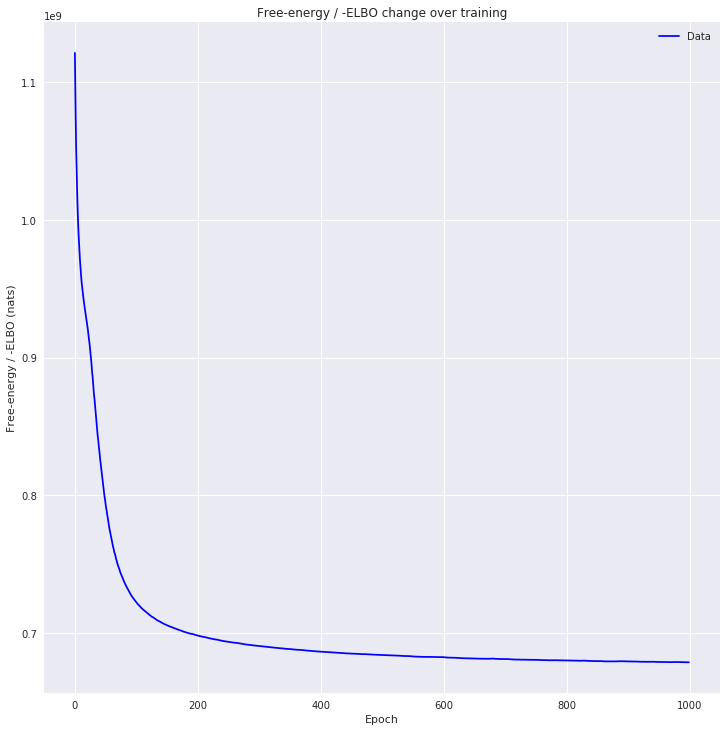

In [9]:
utils.plot_losses(losses)

In [10]:
def subject_labeler(block):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(block.subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        condition = 'Major Depressive'
    elif condition == 'control':
        condition = 'Control'
    return '%s Participant %d' % (condition, int(sub_num))

In [11]:
def task_labeler(block):
    if block.task == 'negative_music':
        task = 'Negative music'
    elif block.task == 'positive_music':
        task = 'Positive music'
    elif block.task == 'negative_nonmusic':
        task = 'Negative sounds'
    elif block.task == 'positive_nonmusic':
        task = 'Positive sounds'
    else:
        task = block.task.capitalize()
    return task

In [12]:
def lepping_2017_labeler(block):
    subject = subject_labeler(block)
    task = task_labeler(block)
    return subject + ', ' + task + ' stimulus'

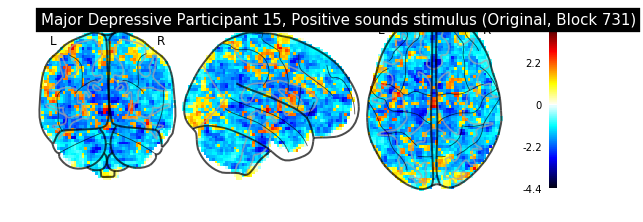

05/20/2019 19:18:05 Reconstruction Error (Frobenius Norm): 5.53492676e+02 out of 6.27538574e+02


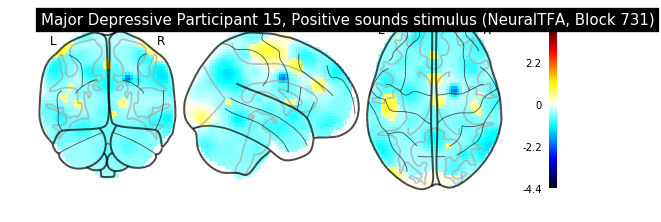

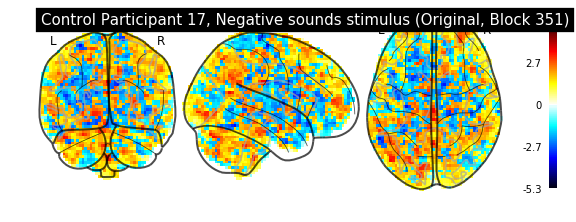

05/20/2019 19:18:08 Reconstruction Error (Frobenius Norm): 6.61400818e+02 out of 7.59354187e+02


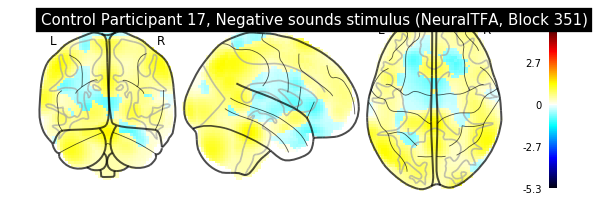

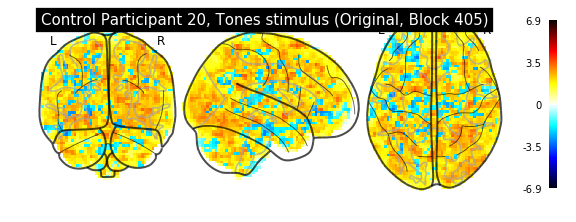

05/20/2019 19:18:11 Reconstruction Error (Frobenius Norm): 7.13800903e+02 out of 8.30933044e+02


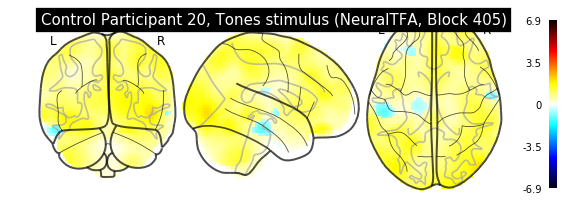

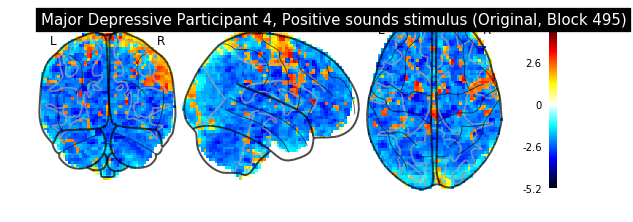

05/20/2019 19:18:14 Reconstruction Error (Frobenius Norm): 6.70306091e+02 out of 9.21104492e+02


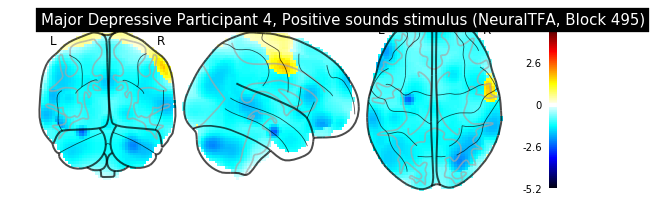

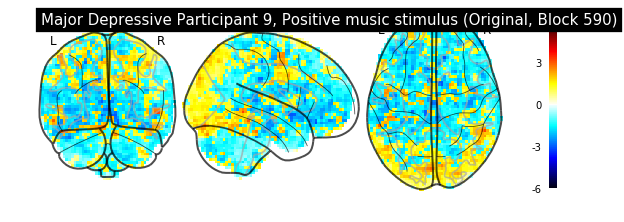

05/20/2019 19:18:17 Reconstruction Error (Frobenius Norm): 5.56000488e+02 out of 6.61393127e+02


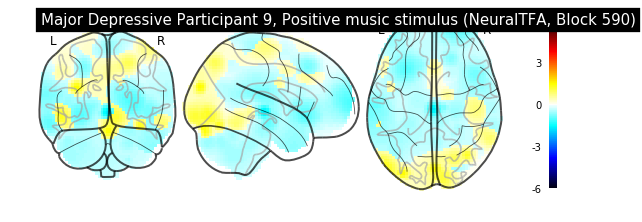

In [13]:
for b in np.random.choice(range(dtfa.num_blocks), 5):
    dtfa.plot_original_brain(b, labeler=lepping_2017_labeler)
    dtfa.plot_reconstruction(b, labeler=lepping_2017_labeler)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


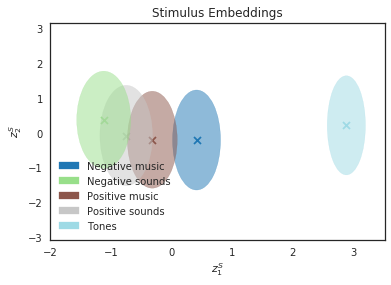

In [14]:
dtfa.scatter_task_embedding(labeler=task_labeler, figsize=None)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


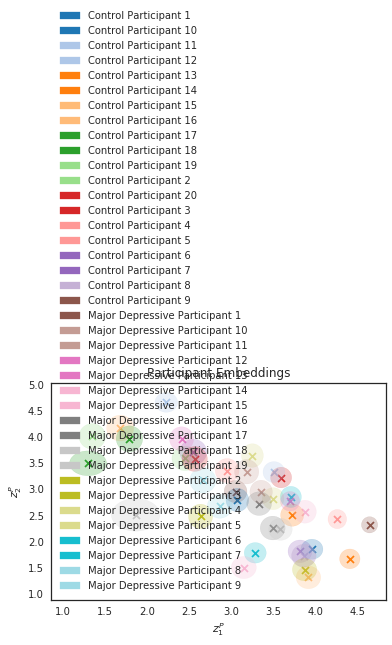

In [15]:
dtfa.scatter_subject_embedding(labeler=subject_labeler, figsize=None)

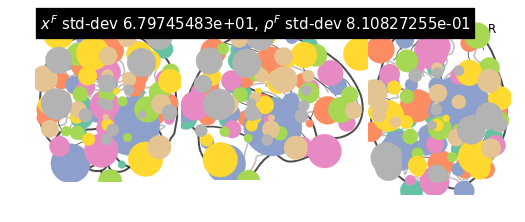

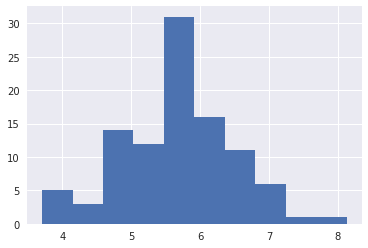

(<nilearn.plotting.displays.OrthoProjector at 0x7f1526658eb8>,
 tensor([[-2.7885e+01, -1.0756e+02, -8.3734e+00],
         [ 4.9340e+01,  6.1975e+00, -3.0487e+00],
         [-4.4754e+00,  4.1809e+01, -1.7796e+00],
         [-9.5189e+00, -3.1371e+01,  5.0401e+01],
         [ 1.4217e+01, -5.1679e+01, -5.7918e+01],
         [ 5.8425e+01, -5.0752e+01,  6.3466e+01],
         [-2.9180e+01, -3.4411e+01, -2.5067e+01],
         [-2.4335e+00,  2.2220e+01,  6.7016e+01],
         [-2.6223e+01, -1.3710e+01,  4.9520e+00],
         [ 2.9783e+01, -4.6528e+01,  1.7844e+01],
         [ 2.3016e+01, -6.3562e+01, -9.7148e+00],
         [ 4.2300e+01, -5.2579e+00,  4.8146e+01],
         [-4.3938e+01, -5.2410e+01,  5.2052e+01],
         [ 2.7171e+00, -7.8556e+01,  6.1900e+01],
         [-2.2713e+01, -1.7940e+01,  4.9190e+01],
         [-6.0652e+01,  4.1459e+01, -1.9856e-01],
         [ 2.8592e+01,  6.7325e+01,  1.5553e+01],
         [ 2.8215e+01, -8.3615e+01,  2.6353e+01],
         [ 3.2766e+01,  4.7827e+01,  

In [16]:
dtfa.visualize_factor_embedding()

In [17]:
dtfa.average_reconstruction_error()

05/20/2019 19:18:59 Average reconstruction error (MSE): 6.69166226e-01
05/20/2019 19:18:59 Average data norm (Euclidean): 9.57125408e-01
05/20/2019 19:18:59 Percent average reconstruction error: 0.273068


(0.6691662260116281, 0.9571254076478555, 0.002730675437632649)

In [18]:
def condition_labeler(block):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(block.subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        return 'Major Depressive'
    elif condition == 'control':
        return 'Control'
    return condition

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


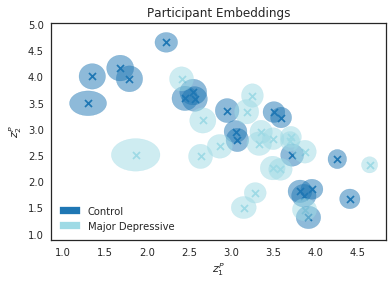

In [19]:
dtfa.scatter_subject_embedding(labeler=condition_labeler, figsize=None)

In [20]:
dtfa.average_reconstruction_error(weighted=False)

05/20/2019 19:26:06 Average reconstruction error (MSE): 5.75394119e+02 +/- 8.90432045e+01
05/20/2019 19:26:06 Average data norm (Euclidean): 8.16828495e+02 +/- 1.69827843e+02
05/20/2019 19:26:06 Percent average reconstruction error: 72.296889 +/- 1.28181338e+01


(array([ 585.96105957,  521.27532959,  544.40551758,  525.79174805,
         561.22686768,  547.68054199,  549.3760376 ,  534.97875977,
         566.11273193,  634.98236084,  516.69476318,  531.82104492,
         557.58831787,  535.54333496,  528.38555908,  529.70458984,
         533.72753906,  518.86114502,  529.6105957 ,  546.28900146,
         536.71282959,  636.82373047,  586.98101807,  622.137146  ,
         579.31365967,  586.98309326,  582.51672363,  583.91351318,
         587.99359131,  622.21124268,  607.15270996,  617.99603271,
         591.1505127 ,  640.09039307,  602.50622559,  584.21759033,
         598.90045166,  644.44012451,  573.74365234,  641.40795898,
         581.88427734,  580.68841553,  674.98181152,  548.52282715,
         520.24554443,  503.20007324,  523.77386475,  537.56378174,
         525.46661377,  559.90441895,  528.85321045,  488.92749023,
         522.6171875 ,  534.65985107,  517.40936279,  573.12738037,
         560.09661865,  529.46643066,  548.66571